In [27]:
import numpy as np

# Create a Generator using MT19937
bitgen = np.random.MT19937(seed=42)
rng = np.random.Generator(bitgen)

# Use this generator to sample
print(rng.uniform(0, 1, 1))  # Now uses seeded MT19937

[0.54199389]


In [28]:
#import numpy as np
import random
import heapq
from scipy.stats import t
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import copy


#### Simulation of hospital bed occupancy during burn-in period ( 30 days)
We simulates how hospital bed occupancy evolves during the burn-in period, helping to assess when the system stabilizes before proper data collection begins. 

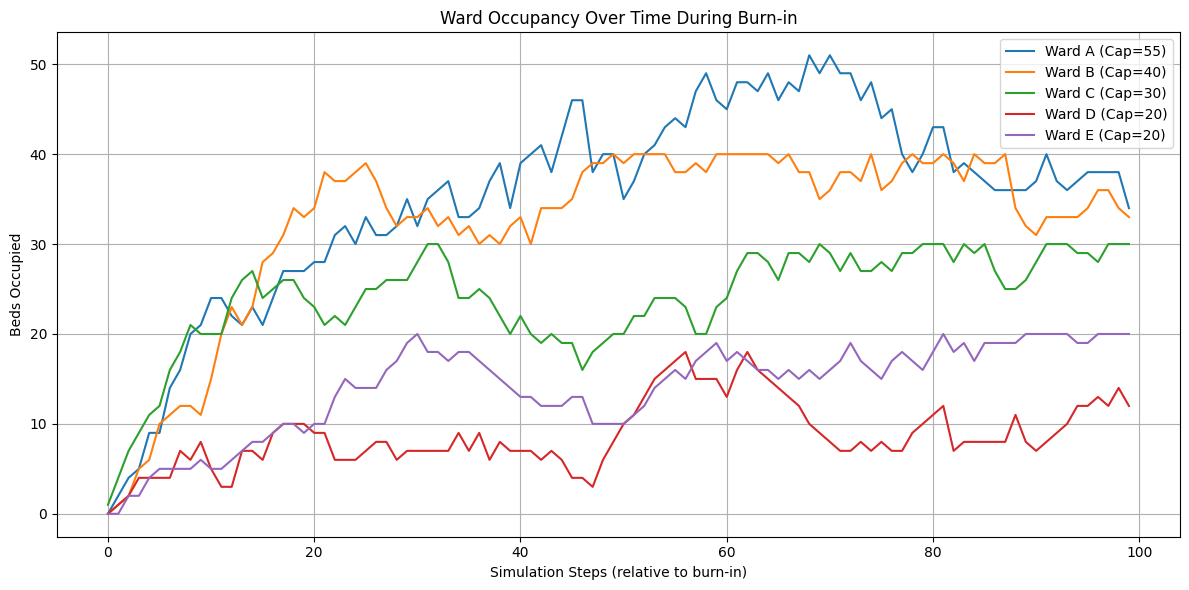

In [26]:
def simulate_burnin_occupancy(n=3000, burn_in=1000, capacity=None, lambda_rates=None, mu_rates=None, P=None, track_time=100):
    """
    Simulates hospital ward occupancy over time to determine burn-in period.
    Returns occupancy time series for each ward.
    """
    if capacity is None:
        capacity = [55, 40, 30, 20, 20]
    if lambda_rates is None:
        lambda_rates = [14.5, 11.0, 8.0, 6.5, 5.0]
    if mu_rates is None:
        mu_rates = [1/2.9, 1/4.0, 1/4.5, 1/1.4, 1/3.9]
    if P is None:
        P = np.array([
            [0.0, 0.05, 0.10, 0.05, 0.80],
            [0.20, 0.0, 0.50, 0.15, 0.15],
            [0.30, 0.20, 0.0, 0.20, 0.30],
            [0.35, 0.30, 0.05, 0.0, 0.30],
            [0.20, 0.10, 0.60, 0.10, 0.0]
        ])
        

    m = len(capacity)
    max_capacity = max(capacity)
    beds = np.full((m, max_capacity), np.nan)
    for i in range(m):
        beds[i, :capacity[i]] = 0  # initialize all usable beds to free

    occupancy_time_series = [[] for _ in range(m)]
    current_time = 0

    for i in range(burn_in):
        arrival_time = np.random.exponential(1 / sum(lambda_rates))
        current_time += arrival_time
        beds = np.where(np.isnan(beds), np.nan, beds - arrival_time)

        patient_type = np.random.choice(m, p=np.array(lambda_rates) / sum(lambda_rates))
        assigned_ward = patient_type
        los = np.random.exponential(1 / mu_rates[patient_type])

        bed_index = np.nanargmin(beds[assigned_ward])
        bed_time = beds[assigned_ward, bed_index]

        if bed_time <= 0:
            beds[assigned_ward, bed_index] = los
        else:
            assigned_ward = np.random.choice(m, p=P[patient_type])
            bed_index = np.nanargmin(beds[assigned_ward])
            bed_time = beds[assigned_ward, bed_index]
            if bed_time <= 0:
                beds[assigned_ward, bed_index] = los
            # else lost (not tracked here)

        if i % (burn_in // track_time) == 0:
            for j in range(m):
                occ = np.sum(beds[j, :] > 0)
                occupancy_time_series[j].append(occ)

    return occupancy_time_series, capacity

# Run and plot
occupancy_time_series, capacity = simulate_burnin_occupancy()
wards = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(12, 6))
for i, series in enumerate(occupancy_time_series):
    plt.plot(series, label=f"Ward {wards[i]} (Cap={capacity[i]})")
plt.xlabel("Simulation Steps (relative to burn-in)")
plt.ylabel("Beds Occupied")
plt.title("Ward Occupancy Over Time During Burn-in")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Based on the plot where we see the bed occupancy regularize itself after burn-in period between 20 -  30 days

#### Simulates Patient Flow in Hospital
We simulates patient flow through a hospital with multiple wards (A–E, optionally F) over a period of days. It models patient arrivals, admissions, transfers, and losses due to full capacity. Here's what it does:

In [14]:
#Determine if F should be included or not. Write FALSE or TRUE
INCLUDE_F = False  # Set to True to include Ward F
WARDS = ['A', 'B', 'C', 'D', 'E'] + (['F'] if INCLUDE_F else [])

# Given Parameters

arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
initial_beds = {'A': 55, 'B': 40, 'C': 30, 'D': 20, 'E': 20, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# Initialization Function
def initialize_events(days=395):
    event_list = []
    np.random.seed(0)
    for ptype in WARDS:
        # no. of arrivals to simulate
        num_arrivals = int( arrival_rates[ptype] * days) 
        # mean time between arrivals
        mean_interarrival_time = 1 / arrival_rates[ptype]
        # Generate interarrival time
        interarrival_times = np.random.exponential(mean_interarrival_time, num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

# Event Handling
def handle_arrival(event, bed, stay_means, penalties, blocked, event_list,
                   patients_total, patients_admitted, patients_relocated,
                   patients_lost, bed_full_events, burnin):
    time, _, ptype = event
    if time >= burnin:
        patients_total[ptype] += 1

    if bed[ptype] > 0:
        bed[ptype] -= 1
        los = np.random.exponential(stay_means[ptype]) # length of stay
        heapq.heappush(event_list, (time + los, 'Dep', ptype))
        if time >= burnin:
            patients_admitted[ptype] += 1
    else: # If no bed is available
        dests = list(relocation_probs[ptype].keys())
        probs = list(relocation_probs[ptype].values())
        dest = random.choices(dests, probs)[0] #We randomly choose a destination ward based on these prob
        heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))  # same time for transfer
        if time >= burnin:
            bed_full_events[ptype] += 1
            penalties[ptype] += urgency_points[ptype]

    return bed, penalties, blocked

def handle_departure(event, bed):
    _, _, ptype = event
    bed[ptype] += 1
    return bed


def handle_transfer(event, bed, stay_means, penalties, blocked, event_list,
                    patients_relocated, patients_lost, patients_admitted, burnin):
    time, _, (from_type, dest) = event
    if bed[dest] > 0:
        bed[dest] -= 1
        if time >= burnin:
            patients_relocated[from_type] += 1
        los = np.random.exponential(stay_means[from_type])
        heapq.heappush(event_list, (time + los, 'Dep', dest))
    else:
        if time >= burnin:
            patients_lost[from_type] += 1
            blocked += 1

    return bed, penalties, blocked

# Main Simulation Function
def simulate_hospital_flow(days=395, burnin=50, bed_config=None):
    bed = bed_config.copy() if bed_config else initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}
    bed_full_events = {w: 0 for w in WARDS}


    while event_list:
        event = heapq.heappop(event_list)
        event_type = event[1]

        if event_type == 'Arr':
            bed, penalties, blocked = handle_arrival(
            event, bed, stay_means, penalties, blocked, event_list,
            patients_total, patients_admitted, patients_relocated, patients_lost, bed_full_events, burnin)


        elif event_type == 'Dep':
            bed = handle_departure(event, bed)

        elif event_type == 'Tra':
            bed, penalties, blocked = handle_transfer(
            event, bed, stay_means, penalties, blocked, event_list,
            patients_relocated, patients_lost, patients_admitted, burnin)


    # Compute metrics
    fraction_direct = {
        w: patients_admitted[w] / patients_total[w] if patients_total[w] > 0 else 0
        for w in WARDS
    }
    prob_full = {
        w: bed_full_events[w] / patients_total[w] if patients_total[w] > 0 else 0
        for w in WARDS
    }
   
    total_penalty = sum(penalties.values())

    # Output results
    #print("\n--- Simulation Results ---")
    #for w in WARDS:
    #    print(f"Ward {w}")
    #    print(f"  N: patients   = {patients_total[w]}")
    #    print(f"  N: directly admitted   = {patients_admitted[w]}")
    #    print(f"  N: relocated  = {patients_relocated[w]}")
    #    print(f"  N: lost       = {patients_lost[w]}")
    #    print(f"  Penalty       = {penalties[w]}")
    #    print(f"  Fraction Directly Admitted        = {fraction_direct[w]:.4f}")
    #    print(f"  Probability Beds Full on Arrival  = {prob_full[w]:.4f}")
    #print(f"\nTotal blocked patients: {blocked}")
    ##print(f"\nTotal penalty points: {total_penalty}")
    return (
    patients_total,
    patients_admitted,
    patients_relocated,
    patients_lost,
    penalties,
    blocked,
    bed_full_events,  # per-ward dict
    total_penalty     # scalar
)

# ▶ Run it
simulate_hospital_flow()


({'A': 5002, 'B': 3771, 'C': 2738, 'D': 2219, 'E': 1693},
 {'A': 4746, 'B': 2909, 'C': 1822, 'D': 2157, 'E': 1204},
 {'A': 134, 'B': 603, 'C': 735, 'D': 50, 'E': 333},
 {'A': 122, 'B': 259, 'C': 181, 'D': 12, 'E': 156},
 {'A': 1792, 'B': 4310, 'C': 1832, 'D': 620, 'E': 2445},
 730,
 {'A': 256, 'B': 862, 'C': 916, 'D': 62, 'E': 489},
 10999)

#### Average estimates

In [15]:
def run_multiple_simulations(n=50, bed_config=None):
    totals = {w: 0 for w in WARDS}
    admitted = {w: 0 for w in WARDS}
    relocated = {w: 0 for w in WARDS}
    lost = {w: 0 for w in WARDS}
    penalties = {w: 0 for w in WARDS}
    bed_full_events_total = {w: 0 for w in WARDS}
    total_blocked_all = 0
    total_penalties = 0

    for _ in range(n):
        pts_total, pts_admitted, pts_relocated, pts_lost, pen, blocked, bed_full, total_penalty = simulate_hospital_flow(bed_config=bed_config)
        for w in WARDS:
            totals[w] += pts_total[w]
            admitted[w] += pts_admitted[w]
            relocated[w] += pts_relocated[w]
            lost[w] += pts_lost[w]
            penalties[w] += pen[w]
            bed_full_events_total[w] += bed_full[w]
        total_blocked_all += blocked
        total_penalties += total_penalty

    # Averages
    avg_totals = {w: totals[w] / n for w in WARDS}
    avg_admitted = {w: admitted[w] / n for w in WARDS}
    avg_relocated = {w: relocated[w] / n for w in WARDS}
    avg_lost = {w: lost[w] / n for w in WARDS}
    avg_penalties = {w: penalties[w] / n for w in WARDS}
    avg_bed_full = {w: bed_full_events_total[w] / n for w in WARDS}
    avg_total_penalties = total_penalties / n
    avg_total_blocked = total_blocked_all / n

    print(f"\n=== Averaged Results over {n} Simulations ===")
    for w in WARDS:
        avg_total = avg_totals[w]
        avg_adm = avg_admitted[w]
        avg_rel = avg_relocated[w]
        avg_lost_w = avg_lost[w]
        avg_pen = avg_penalties[w]
        avg_full = avg_bed_full[w]
        frac = avg_adm / avg_total if avg_total > 0 else 0
        prob = avg_full / avg_total if avg_total > 0 else 0

        print(f"\nWard {w}")
        print(f"  Avg patients            = {avg_total:.1f}")
        print(f"  Avg admitted            = {avg_adm:.1f}")
        print(f"  Avg relocated           = {avg_rel:.1f}")
        print(f"  Avg lost                = {avg_lost_w:.1f}")
        print(f"  Avg penalty             = {avg_pen:.1f}")
        print(f"  Avg full on arrival     = {avg_full:.1f}")
        print(f"  Avg directly admitted % = {frac:.4f}")
        print(f"  Probability full on arrival = {prob:.4f}")

    print(f"\nAvg total blocked patients per run: {avg_total_blocked:.1f}")
    print(f"Avg total penalty points per run: {avg_total_penalties:.1f}")

    return (
        avg_totals,
        avg_admitted,
        avg_relocated,
        avg_lost,
        avg_penalties,
        avg_bed_full,
        avg_total_blocked,
        avg_total_penalties
    )


#### Plotting


=== Averaged Results over 50 Simulations ===

Ward A
  Avg patients            = 5002.0
  Avg admitted            = 4742.9
  Avg relocated           = 135.3
  Avg lost                = 123.8
  Avg penalty             = 1814.0
  Avg full on arrival     = 259.1
  Avg directly admitted % = 0.9482
  Probability full on arrival = 0.0518

Ward B
  Avg patients            = 3771.0
  Avg admitted            = 2956.6
  Avg relocated           = 563.6
  Avg lost                = 250.7
  Avg penalty             = 4071.8
  Avg full on arrival     = 814.4
  Avg directly admitted % = 0.7840
  Probability full on arrival = 0.2160

Ward C
  Avg patients            = 2738.0
  Avg admitted            = 1765.1
  Avg relocated           = 783.3
  Avg lost                = 189.6
  Avg penalty             = 1945.7
  Avg full on arrival     = 972.9
  Avg directly admitted % = 0.6447
  Probability full on arrival = 0.3553

Ward D
  Avg patients            = 2219.0
  Avg admitted            = 2139.5
  Avg rel

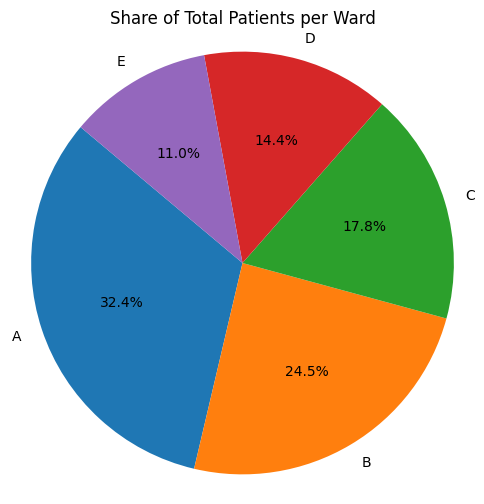

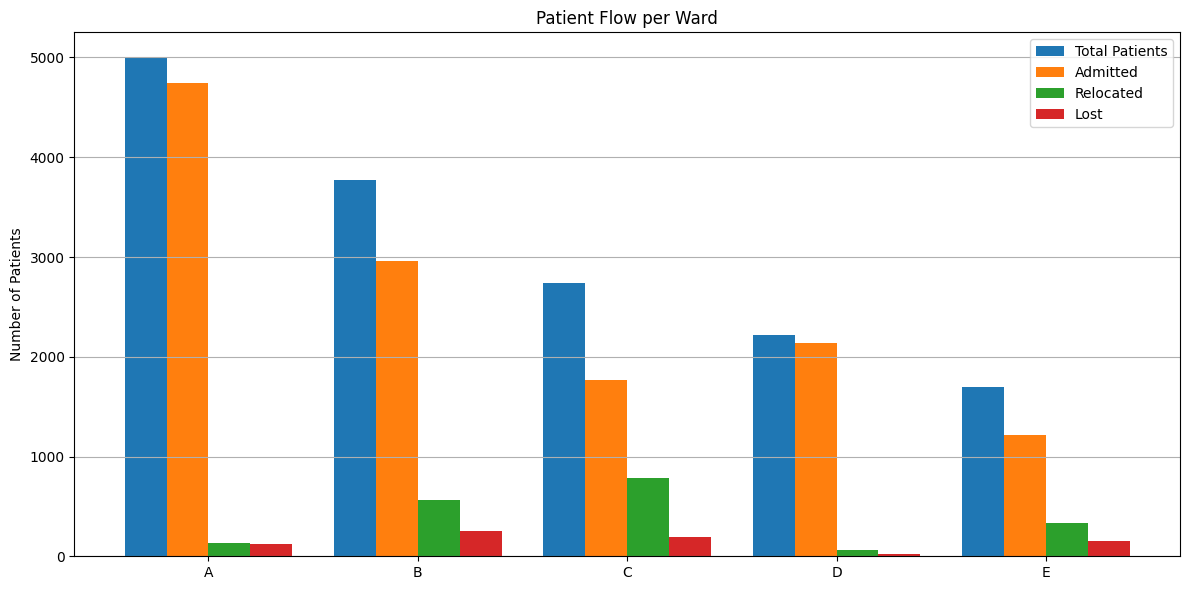

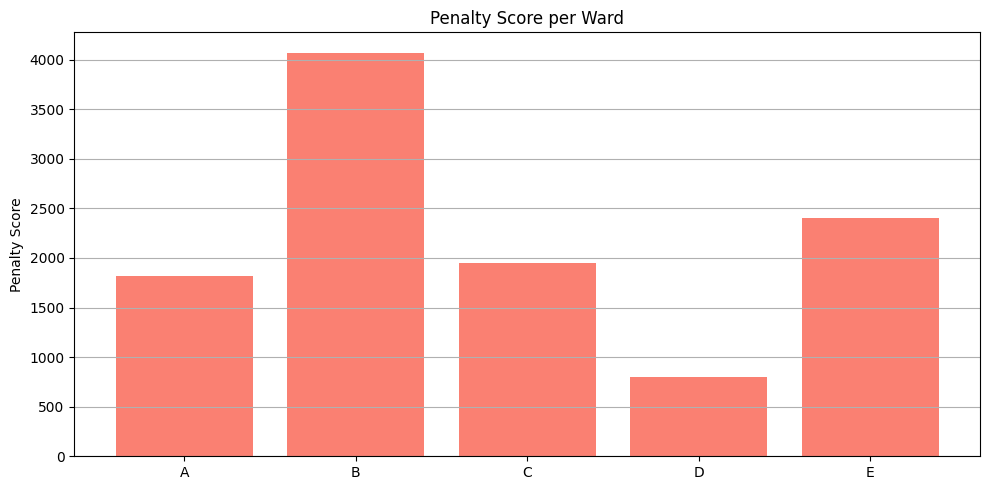

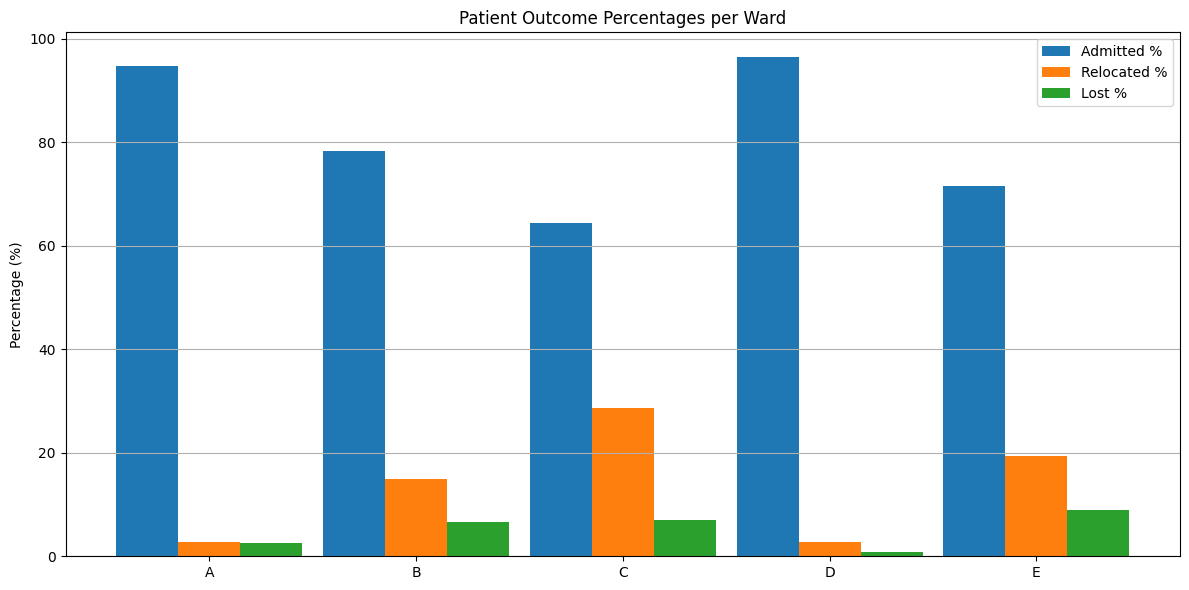

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


# --- Pie Chart: Share of Total Patients per Ward ---
def plot_pie_total_patients(patients_total):
    labels = patients_total.keys()
    sizes = patients_total.values()

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Share of Total Patients per Ward')
    plt.axis('equal')
    plt.show()

# --- Bar Plot: Percentages of Outcomes per Ward ---
def plot_outcome_percentages(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    admitted_pct = [patients_admitted[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    relocated_pct = [patients_relocated[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    lost_pct = [patients_lost[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]

    x = np.arange(len(wards))
    width = 0.3

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, admitted_pct, width, label='Admitted %')
    plt.bar(x, relocated_pct, width, label='Relocated %')
    plt.bar(x + width, lost_pct, width, label='Lost %')

    plt.xticks(x, wards)
    plt.ylabel('Percentage (%)')
    plt.title('Patient Outcome Percentages per Ward')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Raw Patient Flow Counts ---
def plot_patient_flow(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    totals = [patients_total[w] for w in wards]
    admitted = [patients_admitted[w] for w in wards]
    relocated = [patients_relocated[w] for w in wards]
    lost = [patients_lost[w] for w in wards]

    x = np.arange(len(wards))
    width = 0.2

    plt.figure(figsize=(12, 6))
    plt.bar(x - 1.5*width, totals, width, label='Total Patients')
    plt.bar(x - 0.5*width, admitted, width, label='Admitted')
    plt.bar(x + 0.5*width, relocated, width, label='Relocated')
    plt.bar(x + 1.5*width, lost, width, label='Lost')

    plt.xticks(x, wards)
    plt.ylabel('Number of Patients')
    plt.title('Patient Flow per Ward')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Penalty Scores per Ward ---
def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Run the simulation 
pt, pa, pr, pl, pen, *_ = run_multiple_simulations(50)


#Plot the results
plot_pie_total_patients(pt)
plot_patient_flow(pt, pa, pr, pl)
plot_penalties(pen)
plot_outcome_percentages(pt, pa, pr, pl)


#### Blocked Patients Percentage

In [ ]:
# Blocked patients as percentage of Total
total_patients = sum(pt.values())
blocked_percentage = (block / total_patients) * 100

print("\n--- Blocked Patients Summary ---")
print(f"Total Arrivals (all wards): {total_patients}")
print(f"Total Blocked Patients     : {block}")
print(f"Blocked Patients %         : {blocked_percentage:.2f}%")

NameError: name 'avg_total_blocked' is not defined

#### Warf F admission capacity performance

To analyze the effect of increasing capacity in Ward F on admission performance. we plot how changing the number of beds in Ward F affects patient admission rates. This helps guide resource allocation decisions, e.g., how many beds Ward F needs to admit at least 95% of its patients directly.

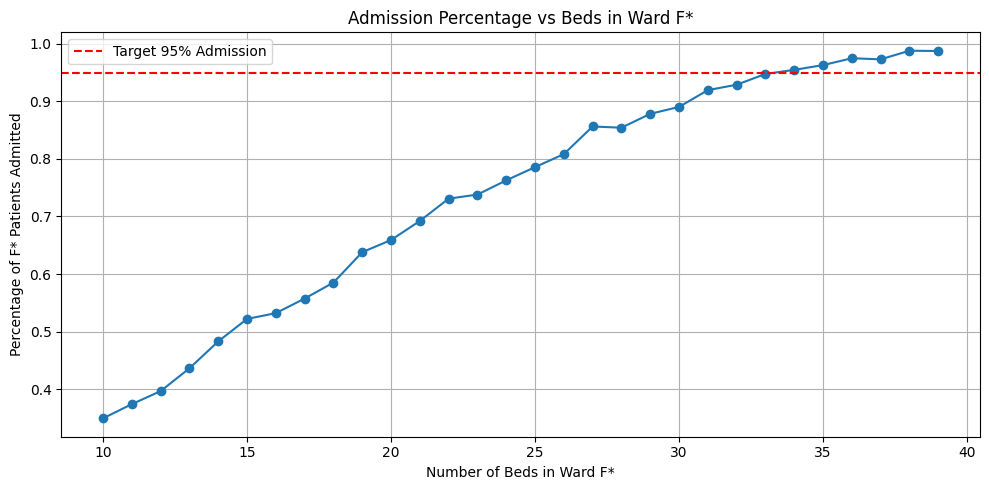

In [20]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

# --- Parameters ---
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# --- Helper Functions ---
def initialize_events(days=365):
    event_list = []
    np.random.seed(0)
    for ptype in WARDS:
        num_arrivals = int(arrival_rates[ptype] * days * 1.2)
        interarrival_times = np.random.exponential(1 / arrival_rates[ptype], num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

def handle_arrival(event, bed, penalties, blocked, event_list, patients_total, patients_admitted, patients_relocated, patients_lost):
    time, _, ptype = event
    patients_total[ptype] += 1
    if bed[ptype] > 0:
        bed[ptype] -= 1
        los = np.random.exponential(stay_means[ptype])
        heapq.heappush(event_list, (time + los, 'Dep', ptype))
        patients_admitted[ptype] += 1
    else:
        penalties[ptype] += urgency_points[ptype]
        dests = list(relocation_probs[ptype].keys())
        probs = list(relocation_probs[ptype].values())
        dest = random.choices(dests, probs)[0]
        heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))
    return bed, penalties, blocked

def handle_departure(event, bed):
    _, _, ptype = event
    bed[ptype] += 1
    return bed

def handle_transfer(event, bed, penalties, blocked, event_list, patients_relocated, patients_lost, patients_admitted):
    time, _, (from_type, dest) = event
    if bed[dest] > 0:
        bed[dest] -= 1
        patients_relocated[from_type] += 1
        patients_admitted[dest] += 1
        los = np.random.exponential(stay_means[from_type])
        heapq.heappush(event_list, (time + los, 'Dep', dest))
    else:
        patients_lost[from_type] += 1
        blocked += 1
    return bed, penalties, blocked

def simulate_hospital_flow(initial_beds, days=365):
    bed = initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}

    while event_list:
        event = heapq.heappop(event_list)
        event_type = event[1]

        if event_type == 'Arr':
            bed, penalties, blocked = handle_arrival(event, bed, penalties, blocked, event_list,
                                                     patients_total, patients_admitted, patients_relocated, patients_lost)
        elif event_type == 'Dep':
            bed = handle_departure(event, bed)
        elif event_type == 'Tra':
            bed, penalties, blocked = handle_transfer(event, bed, penalties, blocked, event_list,
                                                      patients_relocated, patients_lost, patients_admitted)

    return patients_total, patients_admitted, patients_relocated, patients_lost, penalties, blocked

# --- Run over different allocations to F ---
results = []
total_beds = 165
for f_beds in range(10, 40):
    other_beds = total_beds - f_beds
    share = other_beds / 5
    initial_beds = {'A': int(share), 'B': int(share), 'C': int(share), 'D': int(share), 'E': total_beds - f_beds - 4*int(share), 'F': f_beds}
    pt, pa, pr, pl, pen, block = simulate_hospital_flow(initial_beds)
    admitted_pct = pa['F'] / pt['F'] if pt['F'] > 0 else 0
    results.append((f_beds, pt['F'], pa['F'], pr['F'], pl['F'], round(admitted_pct, 4)))

results

# Extract data for plotting
f_beds_vals = [r[0] for r in results]
admit_pct = [r[-1] for r in results]

# Plot admission percentage vs number of F beds
plt.figure(figsize=(10, 5))
plt.plot(f_beds_vals, admit_pct, marker='o', linestyle='-')
plt.axhline(0.95, color='red', linestyle='--', label='Target 95% Admission')
plt.xlabel('Number of Beds in Ward F*')
plt.ylabel('Percentage of F* Patients Admitted')
plt.title('Admission Percentage vs Beds in Ward F*')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Mathematical (Rough) Estimate of Bed distribution
We do a rough estimate of beds in all wards an dcompare it to our Annealing Simulation Estimate. It should roughly be the same

Considering that **Ward F is allocated 34 beds**, the **total number of beds** available for the remaining wards is:

$$
B_N = 165 \quad \Rightarrow \quad B_{\text{remaining}} = B_N - 34 = 131
$$

To estimate how many beds should be allocated to **Ward A**, we compute a **priority-weighted share** based on:

- $ \lambda_i $: patient arrival rate to ward $ i $
- $ \mu_i $: service rate (i.e., discharge rate), where $ \frac{1}{\mu_i} $ is the mean length of stay
- $ UP_i $: urgency points for ward $ i $

We define a **priority-weighted blocking likelihood** for Ward A as:

$$
\Pr(B_A) = \frac{\lambda_A \cdot \frac{1}{\mu_A} \cdot UP_A}{\sum\limits_{i \in \{A, B, C, D, E\}} \lambda_i \cdot \frac{1}{\mu_i} \cdot UP_i}
$$

Then, the **suggested number of beds** to allocate to Ward A is:

$$
B_A = \Pr(B_A) \cdot B_{\text{remaining}} = \Pr(B_A) \cdot (B_N - 34)
$$

This allocation accounts for each ward's demand pressure (arrival rate and length of stay) and the criticality of avoiding rejections (urgency points).


In [96]:
# Define parameters for wards A–E
wards = ['A', 'B', 'C', 'D', 'E']

# Given data
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0}
mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9}  # 1/mu
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5}

# Total beds and fixed beds for Ward F
total_beds = 165
beds_for_F = 34
remaining_beds = total_beds - beds_for_F

# Calculate priority weights
priority_weights = {}
denominator = sum(arrival_rates[w] * mean_stays[w] * urgency_points[w] for w in wards)
for w in wards:
    numerator = arrival_rates[w] * mean_stays[w] * urgency_points[w]
    priority_weights[w] = numerator / denominator

# Compute bed allocation
bed_allocation = {w: round(priority_weights[w] * remaining_beds) for w in wards}
import pandas as pd

# Reconstruct bed allocation dictionary as a DataFrame
bed_allocation_df = pd.DataFrame.from_dict(bed_allocation, orient='index', columns=["Estimated Beds"])
bed_allocation_df.index.name = "Ward"
bed_allocation_df.reset_index(inplace=True)

bed_allocation_df

,Ward,Estimated Beds
0,A,50
1,B,37
2,C,12
3,D,15
4,E,16


#### Simulating the optimal solution with Fixed F = 34

Ward F has 13.0 arrivals/day, which is very high. We consider including F* by reallocating some beds from low-urgency wards to F.

If Ward F* gets 34 beds, and the total remains 165, that leaves 131 beds to be distributed among Wards A–E.

To optimize the distribution of those remaining 131 beds for best overall system performance (e.g. minimizing penalty points or patient loss), the best approach is running a simulated annealing to optimize bed allocation.

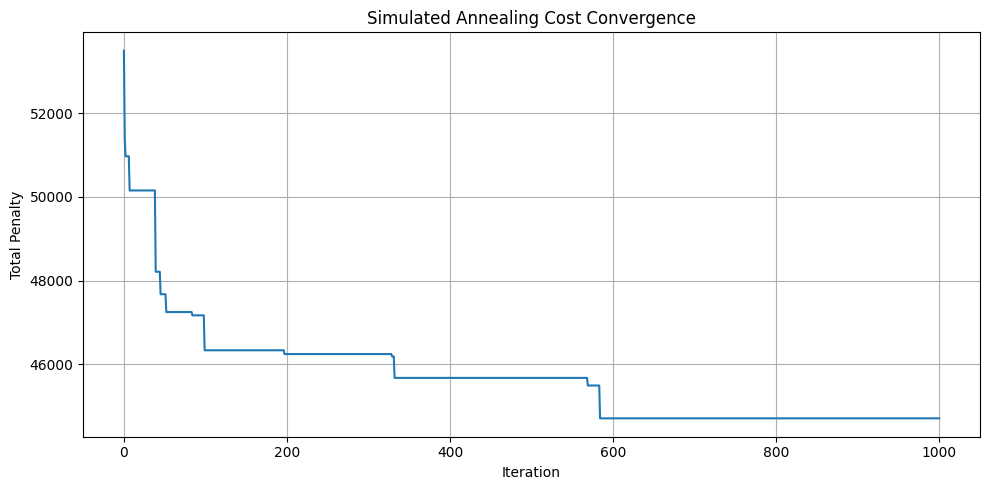

({'A': 28, 'B': 32, 'C': 23, 'D': 22, 'E': 26, 'F': 34}, 44714)

In [29]:
# Re-run after code execution environment reset
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# Initialize events for the simulation
def initialize_events(days=365):
    event_list = []
    for ptype in WARDS:
        num_arrivals = int(arrival_rates[ptype] * days)
        interarrival_times = np.random.exponential(1 / arrival_rates[ptype], num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

# Hospital flow simulation
def simulate_hospital_flow(initial_beds, days=365):
    bed = initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    event_list = initialize_events(days)

    while event_list:
        time, event_type, info = heapq.heappop(event_list)
        if event_type == 'Arr':
            ptype = info
            if bed[ptype] > 0:
                bed[ptype] -= 1
                los = np.random.exponential(stay_means[ptype])
                heapq.heappush(event_list, (time + los, 'Dep', ptype))
            else:
                penalties[ptype] += urgency_points[ptype]
                dests = list(relocation_probs[ptype].keys())
                probs = list(relocation_probs[ptype].values())
                dest = random.choices(dests, probs)[0]
                heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))
        elif event_type == 'Dep':
            ptype = info
            bed[ptype] += 1
        elif event_type == 'Tra':
            from_type, dest = info
            if bed[dest] > 0:
                bed[dest] -= 1
                los = np.random.exponential(stay_means[from_type])
                heapq.heappush(event_list, (time + los, 'Dep', dest))
            else:
                penalties[from_type] += urgency_points[from_type]
    return sum(penalties.values())

# Simulated annealing optimization
def optimize_bed_allocation(total_beds=165, fixed_f=34, k_max=1000, alpha=0.999):
    current = {'A': 26, 'B': 26, 'C': 26, 'D': 26, 'E': 27, 'F': fixed_f}
    best = current.copy()
    best_cost = simulate_hospital_flow(best)
    T0 = 1000

    cost_history = [best_cost]

    for k in range(1, k_max + 1):
        wards = ['A', 'B', 'C', 'D', 'E']
        a, b = random.sample(wards, 2)
        if current[a] > 1:
            neighbor = current.copy()
            neighbor[a] -= 1
            neighbor[b] += 1
            cost = simulate_hospital_flow(neighbor)
            delta = cost - best_cost
            T = T0 * (alpha ** k)

            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                current = neighbor.copy()
                if cost < best_cost:
                    best_cost = cost
                    best = neighbor.copy()
            cost_history.append(best_cost)

    return best, best_cost, cost_history

# Run the optimization
best_allocation, best_penalty, cost_history = optimize_bed_allocation()

# Plot cost history
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Simulated Annealing Cost Convergence")
plt.xlabel("Iteration")
plt.ylabel("Total Penalty")
plt.grid(True)
plt.tight_layout()
plt.show()

best_allocation, best_penalty


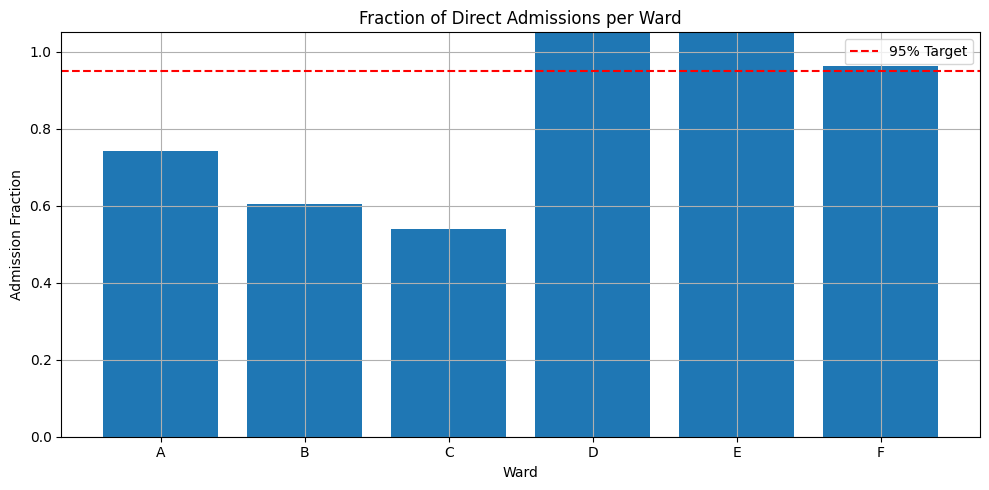

,Total Patients,Admitted,Relocated,Lost,Penalty Points,Admission Fraction,Bed Full Probability,Total Blocked Patients
A,5282.0,3921.0,924.0,1096.0,14140.0,0.7423,0.3824,3292
B,4003.0,2419.0,963.0,938.0,9505.0,0.6043,0.4749,3292
C,2901.0,1565.0,1132.0,734.0,3732.0,0.5395,0.6432,3292
D,2370.0,3212.0,21.0,23.0,440.0,1.3553,0.0186,3292
E,1784.0,2100.0,371.0,440.0,4055.0,1.1771,0.4546,3292
F,4599.0,4430.0,108.0,61.0,0.0,0.9633,0.0367,3292


In [57]:
import heapq
import numpy as np
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

# Wards and parameters
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# Optimized bed allocation
bed_allocation = {'A': 35, 'B': 28, 'C': 19, 'D': 28, 'E': 22, 'F': 34}

# Simulation function
def initialize_events(days=395):
    event_list = []
    for ptype in WARDS:
        num_arrivals = int(arrival_rates[ptype] * days)
        interarrival_times = np.random.exponential(1 / arrival_rates[ptype], num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

def simulate_hospital_flow(initial_beds, days=395, burnin=30):
    bed = initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}
    bed_full_events = {w: 0 for w in WARDS}

    while event_list:
        time, event_type, info = heapq.heappop(event_list)
        if event_type == 'Arr':
            ptype = info
            if time >= burnin:
                patients_total[ptype] += 1
            if bed[ptype] > 0:
                bed[ptype] -= 1
                los = np.random.exponential(stay_means[ptype])
                heapq.heappush(event_list, (time + los, 'Dep', ptype))
                if time >= burnin:
                    patients_admitted[ptype] += 1
            else:
                dests = list(relocation_probs[ptype].keys())
                probs = list(relocation_probs[ptype].values())
                dest = random.choices(dests, probs)[0]
                heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))
                if time >= burnin:
                    penalties[ptype] += urgency_points[ptype]
                    bed_full_events[ptype] += 1
        elif event_type == 'Dep':
            ptype = info
            bed[ptype] += 1
        elif event_type == 'Tra':
            from_type, dest = info
            if bed[dest] > 0:
                bed[dest] -= 1
                if time >= burnin:
                    patients_relocated[from_type] += 1
                    patients_admitted[dest] += 1
                los = np.random.exponential(stay_means[from_type])
                heapq.heappush(event_list, (time + los, 'Dep', dest))
            else:
                if time >= burnin:
                    patients_lost[from_type] += 1
                    blocked += 1

    # Summary metrics
    result_summary = {
        w: {
            "Total Patients": patients_total[w],
            "Admitted": patients_admitted[w],
            "Relocated": patients_relocated[w],
            "Lost": patients_lost[w],
            "Penalty Points": penalties[w],
            "Admission Fraction": round(patients_admitted[w] / patients_total[w], 4) if patients_total[w] else 0,
            "Bed Full Probability": round(bed_full_events[w] / patients_total[w], 4) if patients_total[w] else 0
        }
        for w in WARDS
    }

    return result_summary, blocked

# Run the simulation
simulation_result, total_blocked = simulate_hospital_flow(bed_allocation)

import pandas as pd
df = pd.DataFrame(simulation_result).T
df["Total Blocked Patients"] = total_blocked
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(df.index, df["Admission Fraction"])
plt.axhline(0.95, color='red', linestyle='--', label='95% Target')
plt.title("Fraction of Direct Admissions per Ward")
plt.ylabel("Admission Fraction")
plt.xlabel("Ward")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df
